In [1]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnull, when, count, abs, mean, stddev, log
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, FloatType, NumericType
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re


# Initialize Spark session
spark = SparkSession.builder.appName("WebArticlePopularity").getOrCreate()

# Load dataset
df = spark.read.csv('WebArticlePopularity.csv',header=True, inferSchema=True)

# The column heading names should not contain any special characters like '.'
# Rectifying them to a valid name
new_column_names = {col: re.sub(r'[^a-zA-Z0-9]', '_', col) for col in df.columns}

# Apply the renaming
for old_name, new_name in new_column_names.items():
    df = df.withColumnRenamed(old_name, new_name)

# Verify the new column names
print("New column names:", df.columns)


# Check if data is loaded
if df.count() > 0:
    df.describe().show()
else:
    print("The DataFrame is empty.") 


New column names: ['url', 'article_age', 'no_of_words_in_title', 'no_of_words_in_article', 'unique_words_vs_total_words', 'nonstop_words_vs_total_words', 'unique_nonstop_words_vs_total_words', 'no_of_links', 'no_of_links_to_other_articles', 'no_of_images', 'no_of_videos', 'average_length_of_words', 'no_of_keywords_in_metadata', 'is_article_section_lifestyle', 'is_article_section_entertainment', '_is_article_section_business', 'is_article_section_socialmedia', 'is_article_section_tech', 'is_article_section_world', 'Worst_keyword__min__shares_', 'Worst_keyword__max__shares_', 'Worst_keyword__avg__shares_', 'Best_keyword__min__shares_', 'Best_keyword__max__shares_', 'Best_keyword__avg__shares_', 'Avg_keyword__min__shares_', 'Avg_keyword__max__shares_', 'Avg_keyword__avg__shares_', 'Minimum_shares_of_referenced_articles_in_some_website', 'Maximum_shares_of_referenced_articles_in_some_website', 'Average_shares_of_referenced_articles_in_some_website', 'article_published_day_is_monday', 'arti

+--------------------+-----------+--------------------+----------------------+---------------------------+----------------------------+-----------------------------------+-----------+-----------------------------+------------+------------+-----------------------+--------------------------+----------------------------+--------------------------------+----------------------------+------------------------------+-----------------------+------------------------+---------------------------+---------------------------+---------------------------+--------------------------+--------------------------+--------------------------+-------------------------+-------------------------+-------------------------+-----------------------------------------------------+-----------------------------------------------------+-----------------------------------------------------+-------------------------------+--------------------------------+----------------------------------+---------------------------------+

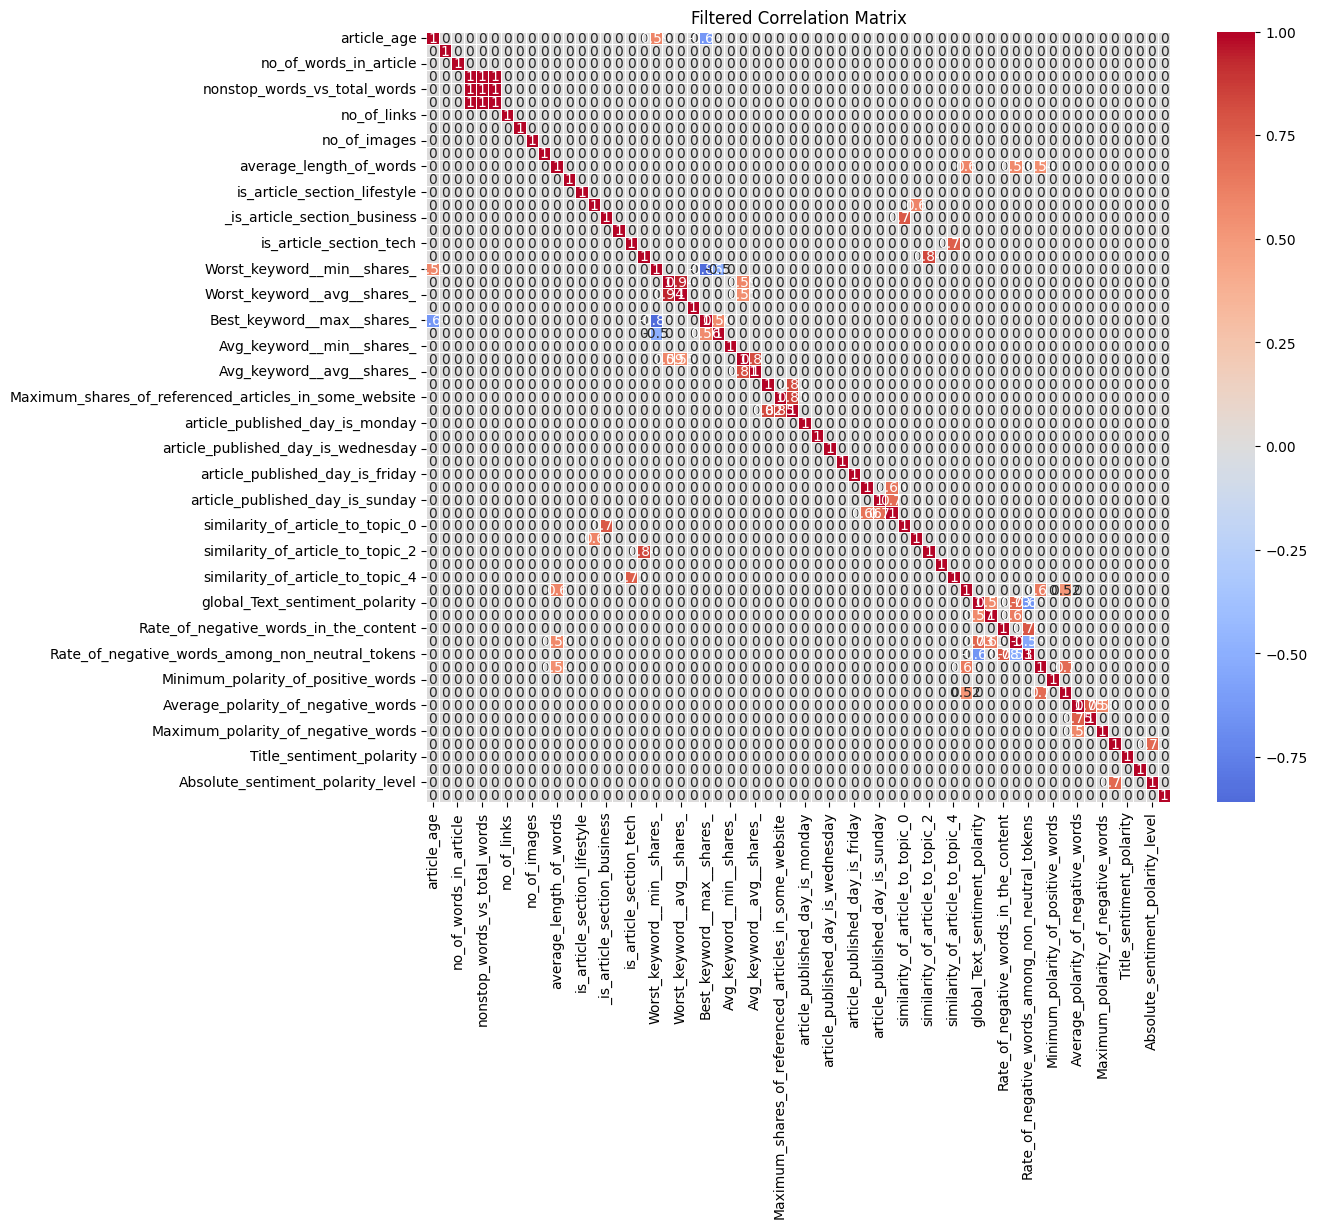

In [2]:
# Visualisation

    
# Print 5 rows for sanity check
df.show(5)
# print(df.dtypes)

# Print description and shape of the dataset
df.describe().show()

## Finding correlation matrix/heat map
# Select only numeric columns for correlation analysis
numeric_columns = [c for c, dtype in df.dtypes if dtype in ('int', 'double')]
df_numeric = df.select(numeric_columns)
# Convert to Pandas DataFrame to compute and visualize correlations more easily
df_pd = df_numeric.toPandas()
# Compute correlation matrix
correlation_matrix = df_pd.corr()

# Filter out weak correlations below a threshold (e.g., 0.5) for clarity
threshold = 0.5
filtered_matrix = correlation_matrix[correlation_matrix.abs() >= threshold].fillna(0)

# Plot the filtered correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Filtered Correlation Matrix")
plt.show()

In [3]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, FloatType, NumericType


# Check for missing values
missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_counts.show()

# Preprocess each column in one loop
for c in df.columns:
    col_type = df.select(c).dtypes[0][1]
    
    if col_type == 'double':
        # Fill missing values with median
        median_value = df.approxQuantile(c, [0.5], 0.25)[0]
        df = df.fillna({c: median_value})
        
        # Handle outliers using IQR method
        q1, q3 = df.approxQuantile(c, [0.25, 0.75], 0.25)
        iqr = q3 - q1
        lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        df = df.filter((col(c) >= lower_bound) & (col(c) <= upper_bound))
        
        # Apply log transformation to handle skewness if skewness > 1
        skewness = df.selectExpr(f"skewness({c})").collect()[0][0]
        if skewness > 1:
            df = df.withColumn(c, when(col(c) > 0, log(col(c) + 1)).otherwise(0))
    
    elif col_type == 'string':
        # Fill missing values with mode for categorical columns
        mode_value = df.groupBy(c).count().orderBy("count", ascending=False).first()[0]
        df = df.fillna({c: mode_value})

print('#### Pre processing data done successfully ###')


+---+-----------+--------------------+----------------------+---------------------------+----------------------------+-----------------------------------+-----------+-----------------------------+------------+------------+-----------------------+--------------------------+----------------------------+--------------------------------+----------------------------+------------------------------+-----------------------+------------------------+---------------------------+---------------------------+---------------------------+--------------------------+--------------------------+--------------------------+-------------------------+-------------------------+-------------------------+-----------------------------------------------------+-----------------------------------------------------+-----------------------------------------------------+-------------------------------+--------------------------------+----------------------------------+---------------------------------+-----------------

In [4]:
# from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# # Step 1: Initialize Spark Session
# spark = SparkSession.builder.appName("ArticleSharesPrediction").getOrCreate()

# # Step 2: Load Data
# Assuming your data is loaded into a DataFrame `df`
# For example, `df = spark.read.csv("path_to_data.csv", header=True, inferSchema=True)`

# Select relevant features and target column
features = [
    'no_of_links_to_other_articles', 'article_published_day_is_weekend', 'no_of_images', 'no_of_videos'
]
target = 'Number_of_shares_of_the_articles_TARGET_'

# Step 3: Vectorize Features
assembler = VectorAssembler(inputCols=features, outputCol="features")
df = assembler.transform(df).select("features", target)

# Split data into training and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Step 4: Define a function to train and evaluate models
def train_and_evaluate(model, train_data, test_data):
    # Fit the model
    model_fitted = model.fit(train_data)
    
    # Make predictions on training data
    train_predictions = model_fitted.transform(train_data)
    
    # Evaluation on training data
    evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
    train_rmse = evaluator.evaluate(train_predictions)
    
    evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")
    train_r2 = evaluator.evaluate(train_predictions)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Training RMSE: {train_rmse}")
    print(f"Training R^2: {train_r2}")
    print("="*40)
    return model_fitted

# Step 5: Train and Evaluate each model

# Linear Regression
lr = LinearRegression(labelCol=target, featuresCol="features")
lr_model = train_and_evaluate(lr, train_data, test_data)

# Decision Tree Regressor
dt = DecisionTreeRegressor(labelCol=target, featuresCol="features")
dt_model = train_and_evaluate(dt, train_data, test_data)

# Random Forest Regressor
rf = RandomForestRegressor(labelCol=target, featuresCol="features", numTrees=100)
rf_model = train_and_evaluate(rf, train_data, test_data)

# Stop the Spark session


Model: LinearRegression
Training RMSE: 11168.497250009721
Training R^2: 0.0035919902199992304
Model: DecisionTreeRegressor
Training RMSE: 11100.10903973309
Training R^2: 0.015757267220520954
Model: RandomForestRegressor
Training RMSE: 11076.057095818138
Training R^2: 0.02001800076917226


In [ ]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

# Example custom input values (replace with your actual values)
custom_values = {
    'no_of_links_to_other_articles': 10,
    'article_published_day_is_weekend': 0,  # Assuming 0 for weekdays, 1 for weekends
    'no_of_images': 5,
    'no_of_videos': 2
}

# Manually create a DataFrame with required feature columns
custom_df = spark.createDataFrame([
    (custom_values['no_of_links_to_other_articles'], 
     custom_values['article_published_day_is_weekend'], 
     custom_values['no_of_images'], 
     custom_values['no_of_videos'])
], ['no_of_links_to_other_articles', 'article_published_day_is_weekend', 'no_of_images', 'no_of_videos'])

# Verify the structure of the DataFrame
custom_df.show()

# Apply the VectorAssembler to this DataFrame
custom_df = assembler.transform(custom_df)
custom_df.printSchema()


# Show the resulting DataFrame with the features column
custom_df.show()



# Vectorize the custom data using the same VectorAssembler
# custom_df = assembler.transform(custom_df).select("features")

# Make prediction using the trained Linear Regression model
prediction = lr_model.transform(custom_df)

# Show the predicted number of shares for the custom input
prediction.select("prediction").show()


Py4JJavaError: An error occurred while calling o2693.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 231.0 failed 1 times, most recent failure: Lost task 0.0 in stage 231.0 (TID 765) (DESKTOP-HVSJHTL executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4333)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3539)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more
